# Point Spread Function Photometry with Photutils

The PSF photometry module of photutils is intended to be a fully modular tool such that users are able to completly customise the photometry procedure, e.g., by using different source detection algorithms, background estimators, PSF models, etc. Photutils provides implementations for each subtask involved in the photometry process, however, users are still able to include their own implementations without having to touch into the photutils core classes!

This modularity characteristic is accomplished by using the object oriented programming approach which provides a more convient user experience while at the same time allows the developers to think in terms of classes and objects rather than isolated functions.

Photutils provides three basic classes to perform PSF photometry: BasicPSFPhotometry, IterativelySubtractedPSFPhotometry, and DAOPhotPSFPhotometry. In this notebook, we will go through them, explaining their differences and particular uses.

# Artificial Starlist

First things first! Let's create an artifical list of stars using photutils in order to explain the PSF procedures through examples.

In [1]:
from photutils.datasets import make_random_gaussians
from photutils.datasets import make_noise_image
from photutils.datasets import make_gaussian_sources

num_sources = 150
min_flux = 500
max_flux = 5000
min_xmean = 16
max_xmean = 240
sigma_psf = 2.0

starlist = make_random_gaussians(num_sources, [min_flux, max_flux],
                                 [min_xmean, max_xmean],
                                 [min_xmean, max_xmean],
                                 [sigma_psf, sigma_psf],
                                 [sigma_psf, sigma_psf],
                                 random_state=1234)

shape = (256, 256)
image = (make_gaussian_sources(shape, starlist) +
         make_noise_image(shape, type='poisson', mean=6., random_state=1234) + 
         make_noise_image(shape, type='gaussian', mean=0., stddev=2., random_state=1234))

Note that we also added Poisson and Gaussian background noises with the function `make_noise_image`.

Let's keep in mind this fact:

In [2]:
type(starlist)

astropy.table.table.Table

In [3]:
starlist

flux,x_mean,y_mean,x_stddev,y_stddev,theta
float64,float64,float64,float64,float64,float64
1361.83752671,234.286910932,80.0365988307,2.0,2.0,5.19498783924
3299.48946968,165.584266976,237.031376236,2.0,2.0,2.36258382191
2469.77482553,73.2663361612,112.723390062,2.0,2.0,3.82757213879
4034.11362671,40.2617746969,144.628508687,2.0,2.0,3.89571033532
4009.89113653,189.864481991,134.102225175,2.0,2.0,2.77402612406
1726.66672377,191.275070342,60.2742830606,2.0,2.0,1.24892065211
1744.08914814,186.599276805,53.1186888184,2.0,2.0,2.78944286799
4108.42479891,220.826297372,128.221862575,2.0,2.0,5.8104845904
4811.62709158,163.531503155,237.805709459,2.0,2.0,4.21874650364


Yes, Astropy Table is the type expected for almost every functionality in `photutils.psf`

Let's also plot our list of stars.

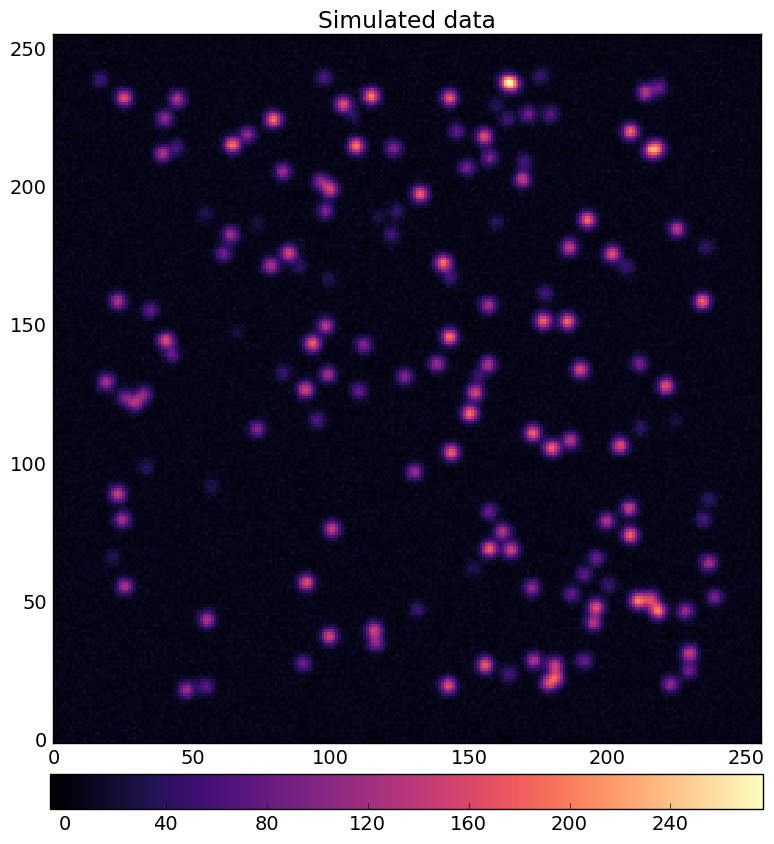

In [4]:
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['image.cmap'] = 'magma'
rcParams['image.aspect'] = 1  # to get images with square pixels
rcParams['figure.figsize'] = (20,10)
rcParams['image.interpolation'] = 'nearest'
rcParams['image.origin'] = 'lower'
rcParams['font.size'] = 14

plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

# The BasicPSFPhotometry class

As the name suggests, this is a basic class which provides the minimum tools necessary to perform photometry in crowded fields (or non crowded fields). Let's take a look into its attributes and methods.

BasicPSFPhotometry has the following mandatory attributes:
    * group_maker : callable or instance of any GroupStarsBase subclass
    * bkg_estimator : callable, instance of any BackgroundBase subclass, or None
    * psf_model : astropy.modeling.Fittable2DModel instance
    * fitshape : integer or length-2 array-like

And the following optional attributes:
    * finder : callable or instance of any StarFinderBase subclasses or None
    * fitter : Astropy Fitter instance
    * aperture_radius : float or int

## Group Maker

`group_maker` can be instantiated using any GroupStarBase subclass, such as `photutils.psf.DAOGroup` or `photutils.psf.DBSCANGroup`, or even using a `callable` provided by the user.

`photutils.psf.DAOGroup` is a class which implements the `GROUP` algorithm proposed by Stetson which is used in DAOPHOT. This class takes one attribute to be initialized namely:
    * crit_separation : int or float
    Distance, in units of pixels, such that any two stars separated by less than this distance will be placed in the same group.

As it is shown in its description, `crit_separation` plays a crucial role in deciding whether or not a given star belong to some group of stars. Usually, `crit_separation` is set to be a positive real number multiplied by the FWHM of the PSF.

`photutils.psf.DBSCANGroup` is a generalized case of `photutils.psf.DAOGroup`, in fact, it is a wrapper around the `sklearn.cluster.DBSCAN` class. Its usage is very similar to `photutils.psf.DAOGroup` and we refer the photutils API doc page for more information: https://photutils.readthedocs.io/en/latest/api/photutils.psf.DBSCANGroup.html#photutils.psf.DBSCANGroup

The user is welcome to check the narrative docs on the photutils RTD webpage: https://photutils.readthedocs.io/en/latest/photutils/grouping.html

Now, let's instantiate a `group_maker` from `DAOGroup`:

In [5]:
from photutils import psf
from astropy.stats import gaussian_sigma_to_fwhm

In [6]:
daogroup = psf.DAOGroup(crit_separation=2.*sigma_psf*gaussian_sigma_to_fwhm)

Now, the object `daogroup` is ready to be passed to `BasicPSFPhotometry`.

## Background Estimation

Background estimation is needed in the photometry process in order to reduce the bias added primarily by Poisson noise background into the flux estimation.

Photutils provides several classes to perform both scalar background estimation, i.e., when the background is flat and does not vary strongly across the image, and spatial varying background estimation, i.e., when there exist a gradient field associated with the background.

The user is welcome to refer to the Background Esimation narrative docs in the photutils webpage for a detailed explanation. https://photutils.readthedocs.io/en/latest/photutils/background.html

In this notebook, we will use the class `MMMBackground` which is intended to estimate scalar background. This class is based on the background estimator used in `DAOPHOT`.

`MMMBackground` gets a `SigmaClip` object as an attribute. It's basically used to perform sigma clip on the image before performing background estimation. For our scenario, we will just instatiate a object of `MMMBackground` with default attribute values:

In [7]:
from photutils import MMMBackground
mmm_bkg = MMMBackground()

In [8]:
mmm_bkg.sigma_clip.sigma

3.0

In [9]:
mmm_bkg.sigma_clip.iters

5

## PSF Models

The attribute ``psf_model`` represents an analytical function with unkwon parameters (e.g., peak center and flux) which describes the underlying point spread function. ``psf_model`` is usually a subclass of `astropy.modeling.Fittable2DModel`. In this notebook, we will use `photutils.psf.IntegratedGaussianPRF` as our underlying PSF model.

Note that the underlying PSF model has to have parameters with the following names ``x_0``, ``y_0``, and ``flux``, to describe the center peak position and the flux, respectively.

In [10]:
from photutils.psf import IntegratedGaussianPRF
gaussian_psf = IntegratedGaussianPRF(sigma=2.0)

## Finder

Finder is an optional attribute, meaning that if it is `None`, then the user should provide a table with the center positions of each star when calling the `BasicPSFPhotometry` object.
Later, we will see examples of both cases, i.e., when Finder is `None` and when it is not.

The finder attribute is used to perform source detection. It can be any subclass of `photutils.StarFinderBase` such as `photutils.DAOStarFinder` or `photutils.IRAFStarFinder`, which implement a DAOPHOT-like or IRAF-like source detection algorithms, respectively. The user can also set her/his own source detection algorithm as long as the input/output formats are compatible with `photutils.StarFinderBase`.

`photutils.DAOStarFinder`, for instance, receives the following mandatory attributes: 
    * threshold : float
        The absolute image value above which to select sources.
    * fwhm : float
        The full-width half-maximum (FWHM) of the major axis of the Gaussian kernel in units of pixels.

Now, let's instantiate our `DAOStarFinder` object:

In [11]:
from photutils.detection import DAOStarFinder

daofinder = DAOStarFinder(threshold=2.5*mmm_bkg(image), fwhm=sigma_psf*gaussian_sigma_to_fwhm)

Note that we choose the `threshold` to be a multiple of the background level and we assumed the `fwhm` to be known from our list of stars.

More details about source detection can be found on the `photutils.detection` narrative docs: https://photutils.readthedocs.io/en/latest/photutils/detection.html

## Fitter

Fitter should be an instance of a fitter implemented in `astropy.modeling.fitting`. Since the PSF model is almost always nonlinear, the fitter should be able to handle nonlinear optimization problems. In this notebook, we will use the `LevMarLSQFitter`, which combines the Levenberg-Marquardt optimization algorithm with the least-squares statistic. The default value for fitter is `LevMarLSQFitter()`.  

Look at http://docs.astropy.org/en/stable/modeling/index.html for more details on fitting.

NOTE: At this point it should be stated tha photutils do not have a standard way to compute uncertainties on the fitted parameters. However, this will change in the near future with the addition of a new affiliated package to the Astropy environment, namely, `SABA: Sherpa-Astropy Bridge` which made possible to use astropy models together with Sherpa Fitters.

## Fitshape and Aperture Radius

There are two attributes left: `fitshape` (mandatory) and `aperture_radius` (optional).
`fitshape` corresponds to the size of the rectangular region necessary to enclose one single source. The pixels inside that region will be used in the fitting process. `fitshape` should be an odd integer or a tuple of odd integers.

In [12]:
import numpy as np
fitshape = 11

The aperture radius corresponds to the radius used to compute initial guesses for the fluxes of the sources. If this value is `None`, then one fwhm will be used if it can be determined by the `psf_model`.

## Example with unknown positions and unknown fluxes

Now we are ready to take a look at an actual example. Let's first create our `BasicPSFPhotometry` object putting together the pieces that we defined along the way:

In [13]:
from photutils.psf import BasicPSFPhotometry
basic_photometry = BasicPSFPhotometry(group_maker=daogroup, bkg_estimator=mmm_bkg,
                                      psf_model=gaussian_psf, fitshape=fitshape,
                                      finder=daofinder)

To actually perform photometry on our image that we defined previously, we should use `basic_photometry` as a function call:

In [14]:
photometry_results = basic_photometry(image)
photometry_results

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit
,,,,,,,
float64,float64,float64,int32,int32,float64,float64,float64
47.8722104412,18.7623486096,2883.5731199,1,1,47.7891062555,18.7328387847,2907.50227636
54.5472047818,19.7792791271,1997.37638718,2,1,54.6977008114,19.8448134617,1797.13558813
142.178386392,20.1964021524,3831.62711488,3,2,142.163322444,20.1924639085,4123.00996292
222.513310508,20.7570456424,2520.83705911,4,3,222.487580523,20.6954987764,2670.31091707
179.836384211,22.5349724045,6981.0069246,7,3,229.153734652,25.6361246057,2032.40990693
164.076438475,24.2131337204,1371.50938094,13,3,229.332730454,31.8600326809,3631.88610041
229.111053172,26.0376600026,2755.6330196,5,4,179.64045225,21.8292515988,5417.12453572
89.8838394599,28.2104878112,1896.85233065,10,4,180.881025374,27.1245779188,4022.32463956


Let's plot the residual image along with the original image:

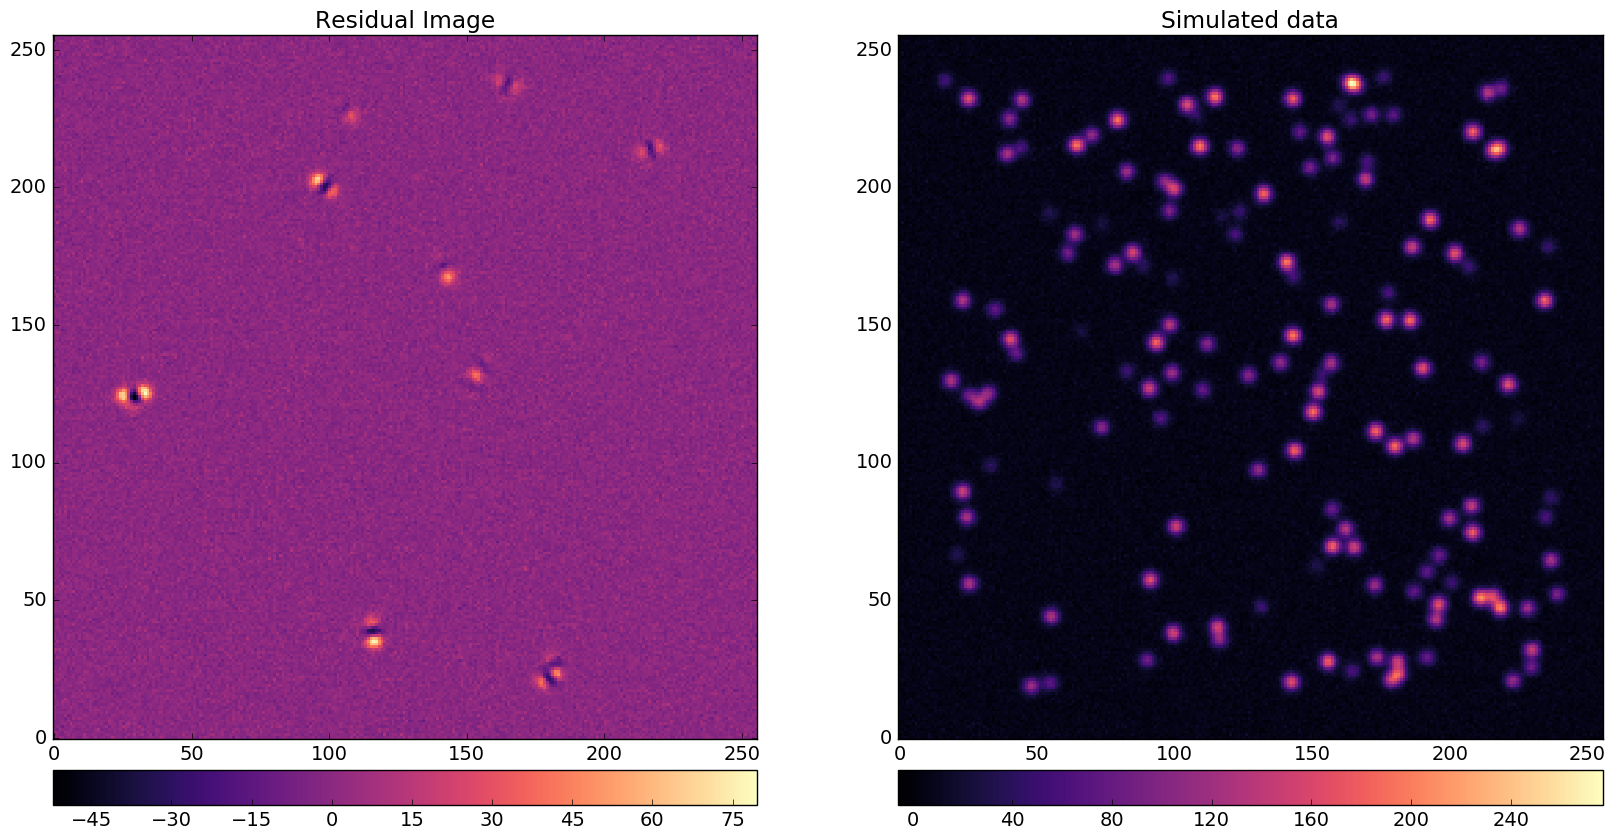

In [15]:
plt.subplot(1,2,1)
plt.imshow(basic_photometry.get_residual_image())
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

Looking at the residual image we observe that the photometry process was able to fit many stars but not all. This is probably due to inability of the source detection algorithm to decide the number of sources in every crowded group. Therefore, let's play with the source detection classes to see whether we can improve the photometry process.

Let's use the `IRAFStarFinder` and play with the optional parameters. A complete description of these parameters can be seen at the `photutils.dection` API documentation: https://photutils.readthedocs.io/en/latest/api/photutils.detection.IRAFStarFinder.html#photutils.detection.IRAFStarFinder

In [16]:
from photutils.detection import IRAFStarFinder
iraffind = IRAFStarFinder(threshold=2.5*mmm_bkg(image),
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)

Now let's set the `finder` attribute of our `BasicPSFPhotometry` object with `iraffind`:

In [17]:
basic_photometry.finder = iraffind

Let's repeat the photometry process:

In [18]:
photometry_results = basic_photometry(image)
photometry_results

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit
,,,,,,,
float64,float64,float64,int32,int32,float64,float64,float64
47.9069374303,18.7890230372,2889.45756841,1,1,47.7891066188,18.7328387677,2907.50251108
54.6667020621,19.8604389506,1967.5407189,2,1,54.6977036017,19.8448143234,1797.13559203
142.129585716,20.1559265569,3832.2001103,3,2,142.163310218,20.1924601528,4123.00464764
222.363461412,20.5327757201,2503.19762576,4,3,222.489373632,20.6956847152,2669.97726705
179.885417965,22.3300535636,6896.09377231,7,3,229.153810854,25.635840492,2032.39900498
164.094957997,24.1513074636,1368.6873483,13,3,229.332737566,31.8599827286,3631.92479858
229.101311041,25.6531244828,2589.01842691,5,4,179.637989036,21.8249711924,5420.22010971
89.8787728187,28.1461144848,1897.42629496,10,4,180.880379416,27.1283174242,4026.68091049


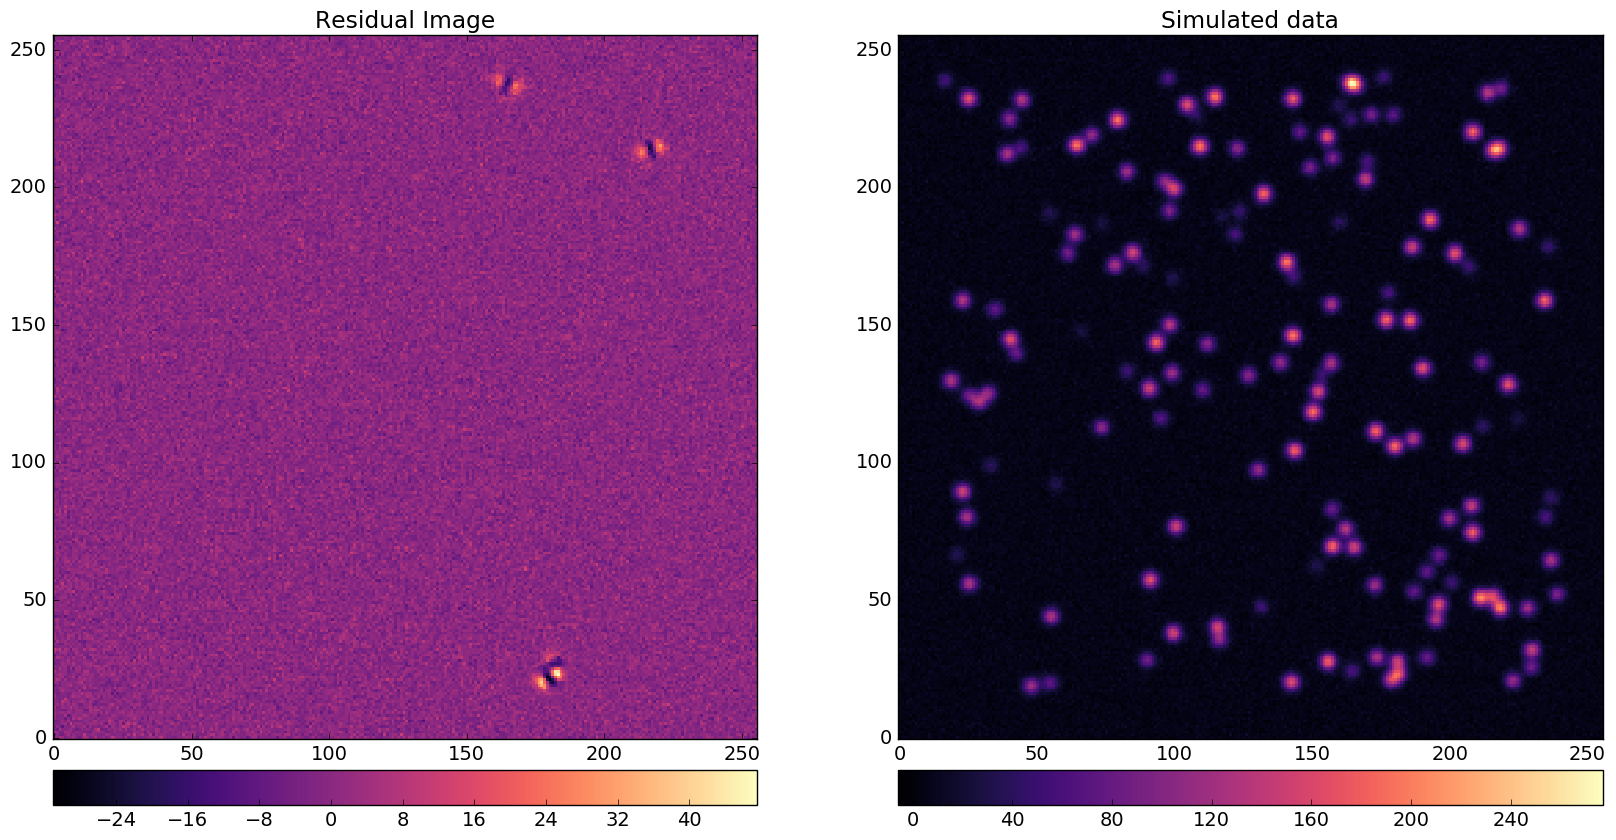

In [19]:
plt.subplot(1,2,1)
plt.imshow(basic_photometry.get_residual_image())
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

As we can see, the residual presents a better Gaussianity with only three groups that were not fitted well. The reason for that is that the sources may be too close to be distinguishable by the source detection algorithm.

## Example with known positions and unknwon fluxes

Let's assume that somehow we know the true positions of the stars and we only would like to perform fitting on the fluxes. Then we should use the optional argument `positions` when calling the photometry object:

In [20]:
from astropy.table import Table
positions = Table(names=['x_0', 'y_0'], data=[starlist['x_mean'], starlist['y_mean']])

In [21]:
photometry_results = basic_photometry(image=image, positions=positions)

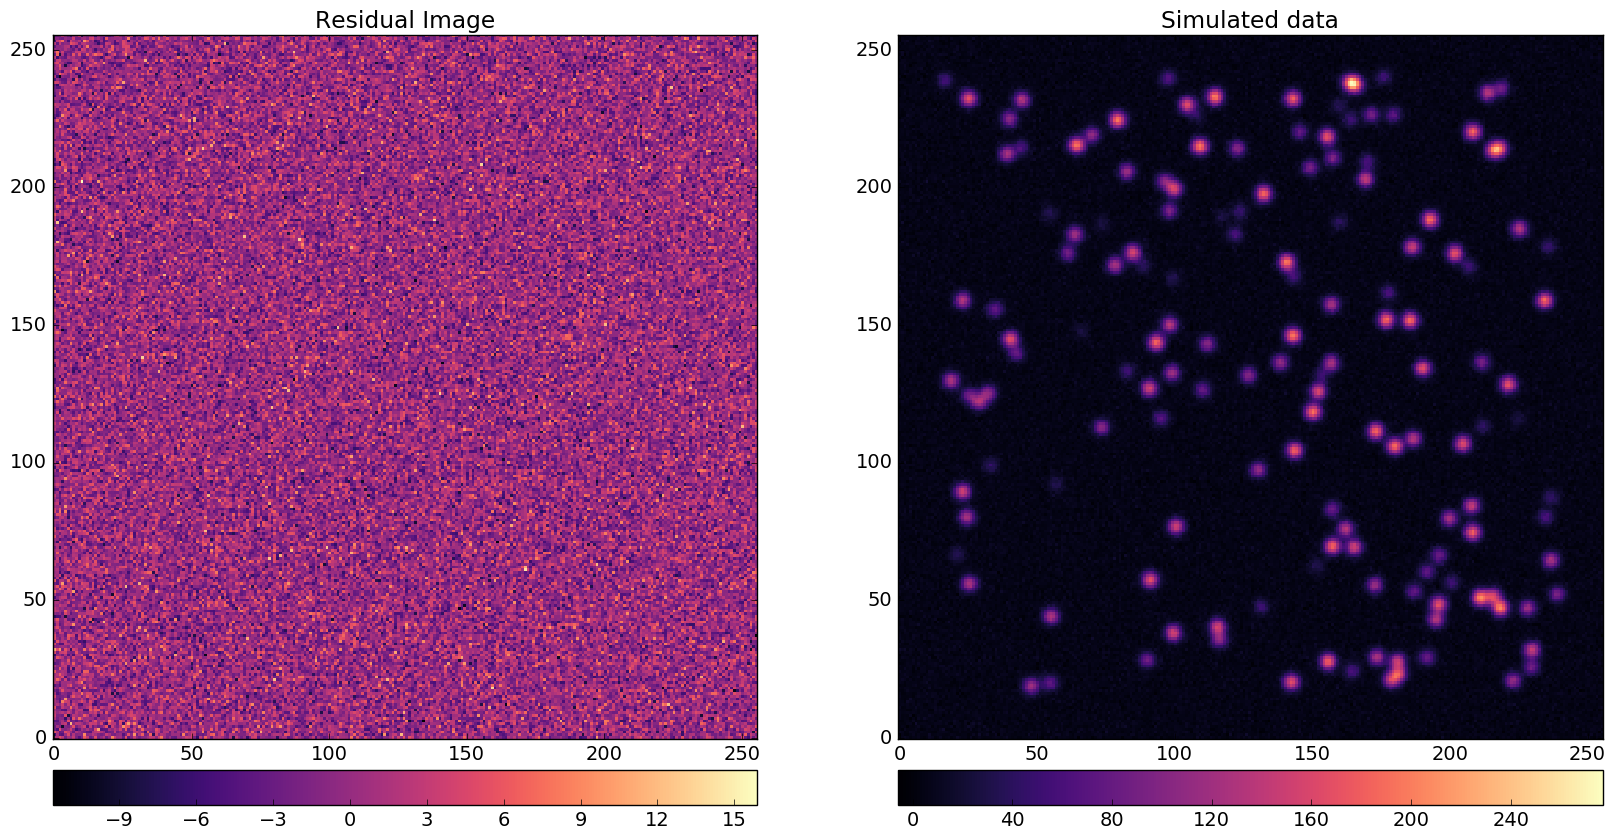

In [22]:
plt.subplot(1,2,1)
plt.imshow(basic_photometry.get_residual_image())
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

Let's do a scatter plot between ground-truth fluxes and estimated fluxes:

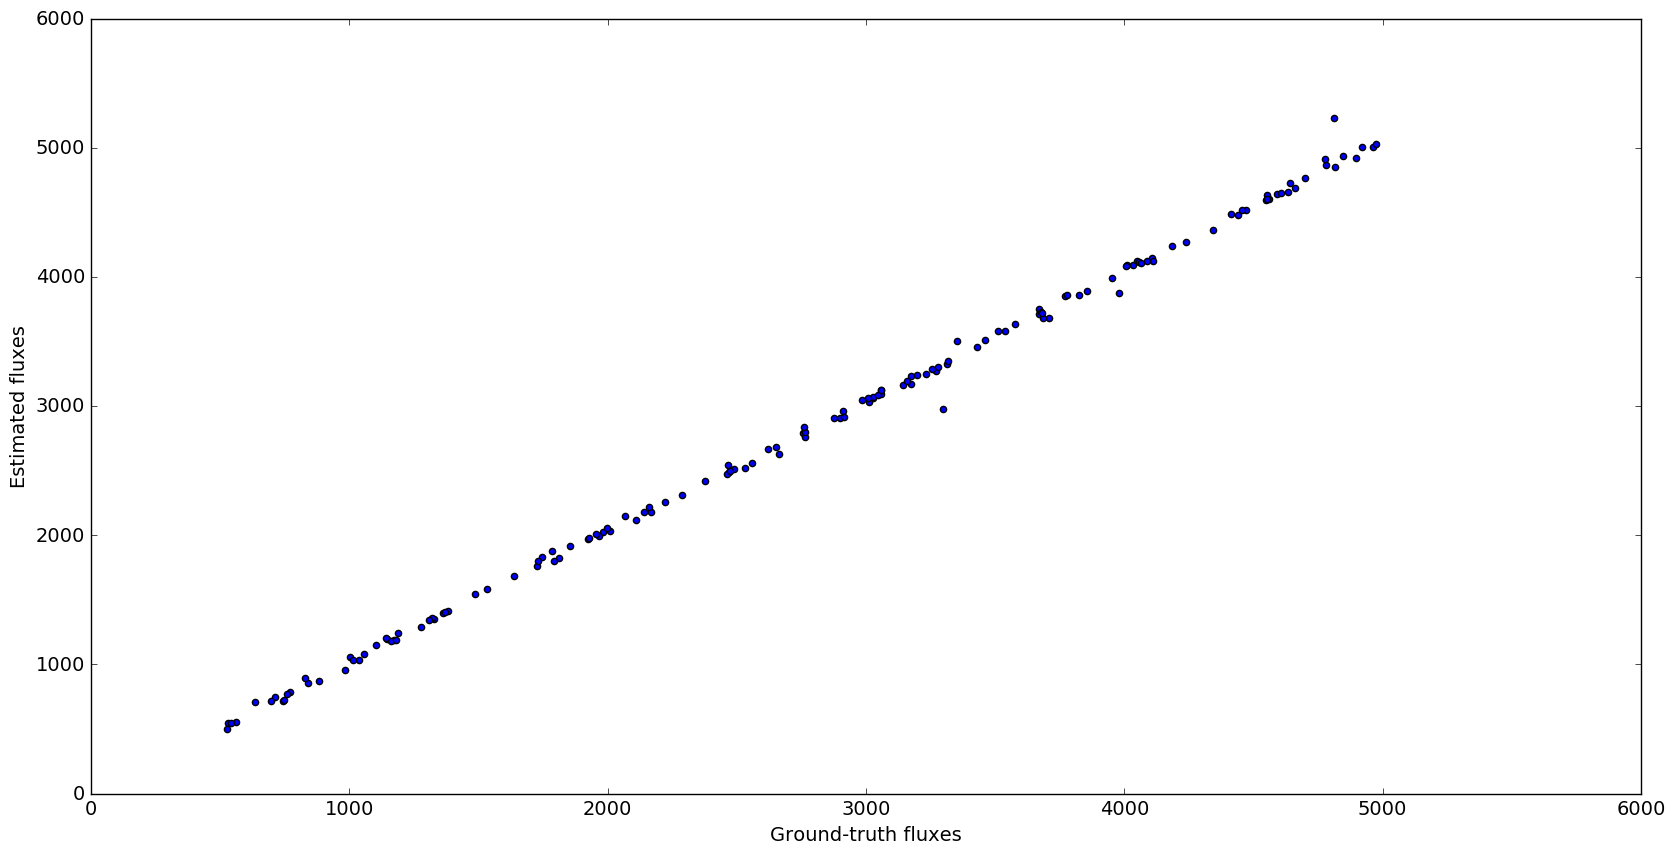

In [23]:
photometry_results.sort('id')
plt.scatter(starlist['flux'], photometry_results['flux_fit'])
plt.xlabel('Ground-truth fluxes')
plt.ylabel('Estimated fluxes')

Let's also plot the relative error on the fluxes estimation as a function of the ground-truth fluxes.

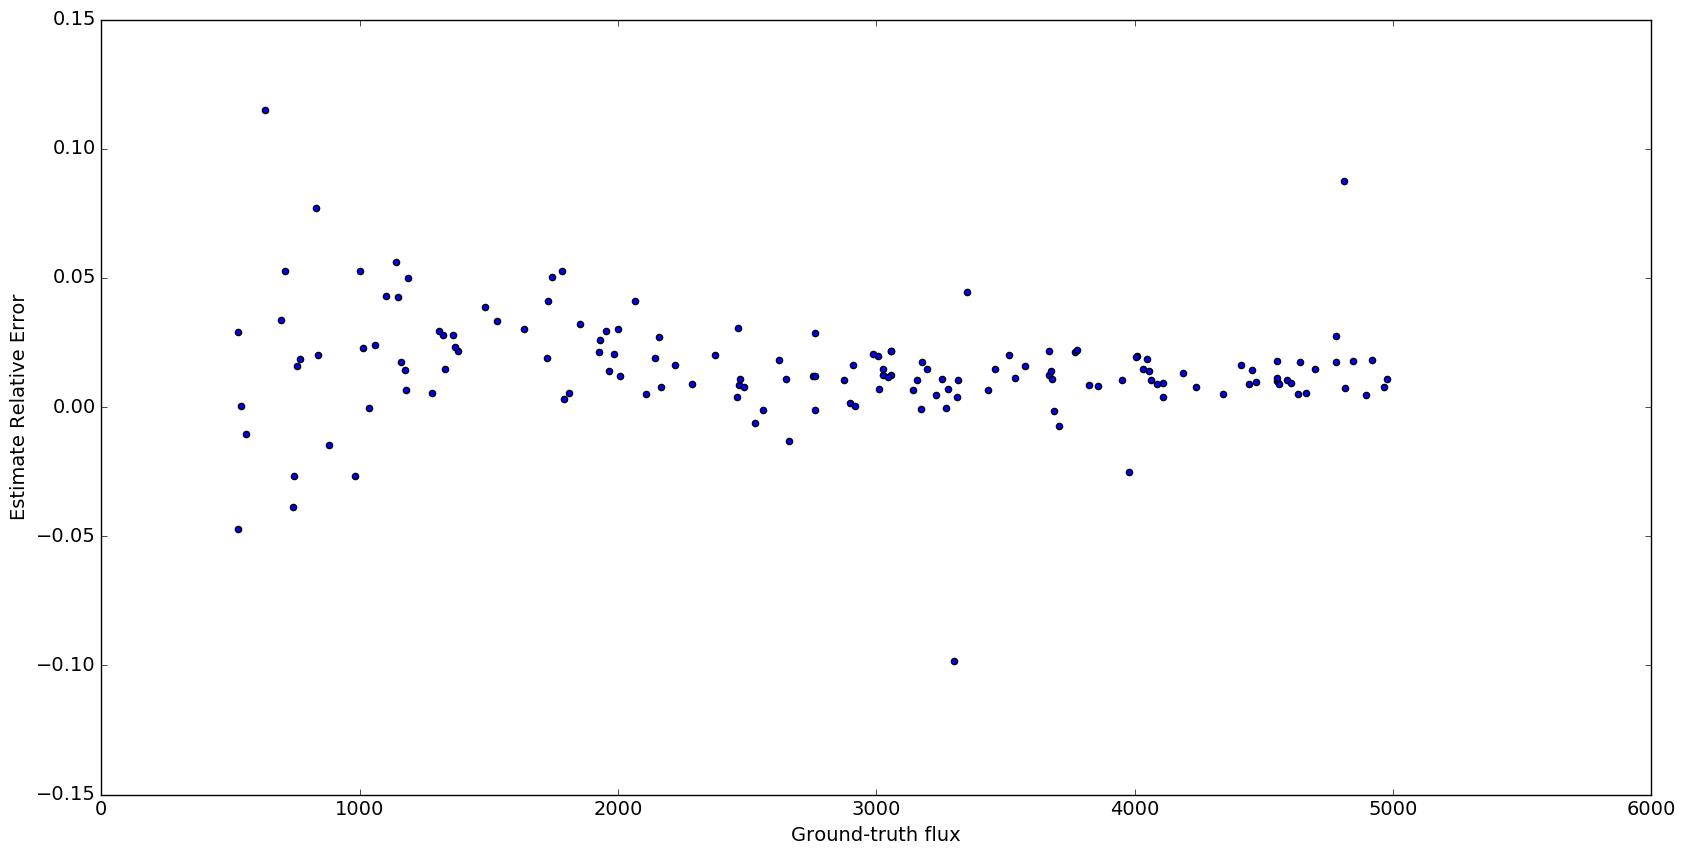

In [24]:
plt.scatter(starlist['flux'], (photometry_results['flux_fit'] - starlist['flux'])/starlist['flux'])
plt.xlabel('Ground-truth flux')
plt.ylabel('Estimate Relative Error')

As we can see, the relative error becomes smaller as the flux increase.

# The IterativelySubtractedPSFPhotometry

`IterativelySubtractedPSFPhotometry` is a subclass of `BasicPSFPhotometry` which adds the iteration functionality to the photometry procedure. It has the same attributes as `BasicPSFPhotometry`, except that it includes an optional one namely `niters` which represents the number of iterations for the photometry procedure.

Therefore, the photometry process implemented in `IterativelySubtractedPSFPhotometry` resembles the DAOPHOT loop: `FIND`, `GROUP`, `NSTAR`, `SUBTRACT`, `FIND`... either until no more sources are detected or a given number of iterations is reached.

The attribute `niters` can be `None`, which means that the photometry procedure will continue until no more sources are detected.

It's worth notice that the attribute `finder` for `IterativelySubtractedPSFPhotometry` can not be `None` (as it can be for `BasicPSFPhotometry`). The reason behind is to keep consistency with the new attribute `niters`, i.e., it would not make sense to have `finder = None` and `niters > 1`.

## Example with unknwon positions and unknown fluxes

Let's instantiate an object of `IterativelySubtractedPSFPhotometry`:

In [25]:
from photutils.psf import IterativelySubtractedPSFPhotometry
itr_phot = IterativelySubtractedPSFPhotometry(group_maker=daogroup, bkg_estimator=mmm_bkg,
                                              psf_model=gaussian_psf, fitshape=fitshape,
                                              finder=iraffind, niters=2)

Let's now perform photometry on our artificil image:

In [26]:
photometry_results = itr_phot(image)
photometry_results

x_0,y_0,flux_0,id,group_id,iter_detected,x_fit,y_fit,flux_fit
,,,,,,,,
float64,float64,float64,int32,int32,int64,float64,float64,float64
47.9069374303,18.7890230372,2889.45756841,1,1,1,47.7891066188,18.7328387677,2907.50251108
54.6667020621,19.8604389506,1967.5407189,2,1,1,54.6977036017,19.8448143234,1797.13559203
142.129585716,20.1559265569,3832.2001103,3,2,1,142.163310218,20.1924601528,4123.00464764
222.363461412,20.5327757201,2503.19762576,4,3,1,222.489373632,20.6956847152,2669.97726705
179.885417965,22.3300535636,6896.09377231,7,3,1,229.153810854,25.635840492,2032.39900498
164.094957997,24.1513074636,1368.6873483,13,3,1,229.332737566,31.8599827286,3631.92479858
229.101311041,25.6531244828,2589.01842691,5,4,1,179.637989036,21.8249711924,5420.22010971
89.8787728187,28.1461144848,1897.42629496,10,4,1,180.880379416,27.1283174242,4026.68091049


Observe that there is a new column namely `iter_detected` which shows the number of the iteration in which that source was detected.

Let's plot the residual image:

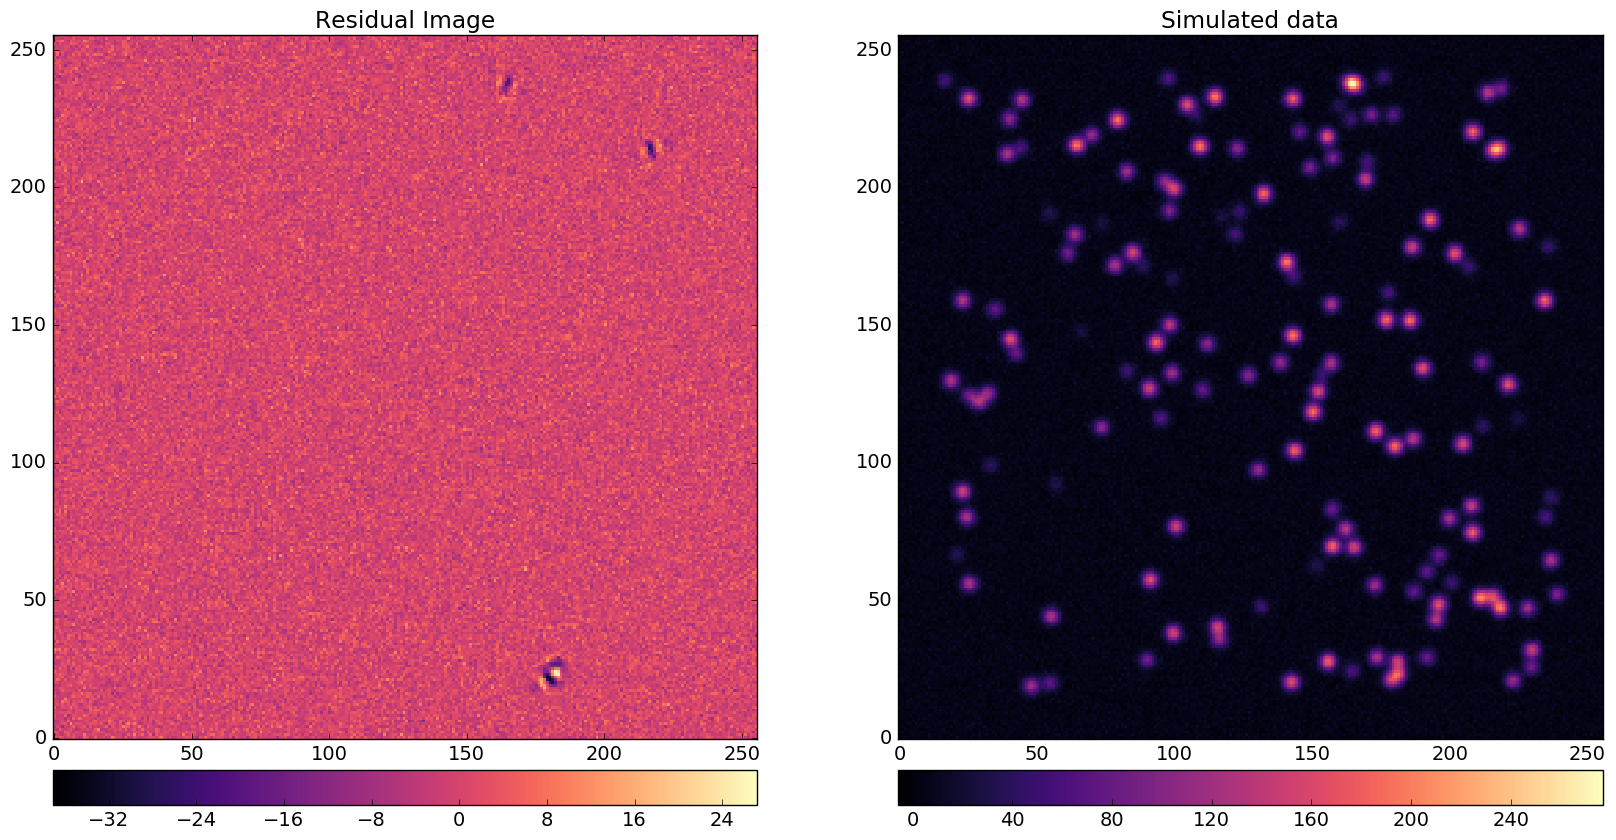

In [27]:
plt.subplot(1,2,1)
plt.imshow(itr_phot.get_residual_image())
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

There is also a class called `DAOPhotPSFPhotometry` that is a subclass of `IterativelySubtractedPSFPhotometry`, but it already sets grouping, background estimator, and finder routines to those correspondent to the DAOPHOT.
We left the use of this class as an exercise to the user to play with the parameters which would optimize the photometry procedure.

## Documentation

Narrative and API docs of the classes used here can be found in https://photutils.readthedocs.io/en/latest/

# Future Works
The PSF Photometry module in photutils is still under development and feedback from users is much appreciated. Please open an issue on the github issue tracker of photutils with any suggestions for improvement, functionalities wanted, bugs, etc. 

Near future implementations in the photutils.psf module include:

* FWHM estimation: a Python equivalent to DAOPHOT psfmeasure.
* Uncertainties computation: uncertainties are very critical and it's very likely that we are going to use astropy saba package to integrate uncertainty computation into photutils.psf.